## Import

In [4]:
import random
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import holidays


import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

from sklearn.model_selection import TimeSeriesSplit


import warnings
warnings.filterwarnings(action='ignore') 

## Fixed RandomSeed

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 42
seed_everything(SEED) # SEED 고정

## Load Data & Pre-Processing

In [6]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
building_info_df = pd.read_csv('building_info.csv')

In [7]:
# building_info.csv의 결측치 처리 및 타입 변환
building_info_df[['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']] = building_info_df[['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']].replace('-', 0).astype(float)
building_info_df = pd.get_dummies(building_info_df, columns=['건물유형'], prefix='건물')

In [8]:
# train, test 데이터에 building_info 병합
train_df = pd.merge(train_df, building_info_df, on='건물번호', how='left')
test_df = pd.merge(test_df, building_info_df, on='건물번호', how='left')

In [9]:
# '일시' 컬럼을 datetime 형식으로 변환
train_df['일시'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')
test_df['일시'] = pd.to_datetime(test_df['일시'], format='%Y%m%d %H')

In [10]:
def create_time_features(df):
    """
    날짜/시간 관련 파생변수를 생성하는 함수입니다.
    """
    df['hour'] = df['일시'].dt.hour
    df['dayofweek'] = df['일시'].dt.dayofweek
    df['month'] = df['일시'].dt.month
    df['day'] = df['일시'].dt.day
    df['weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0) # 주말(토,일)이면 1, 아니면 0
    # 시간의 주기성을 나타내기 위한 sin, cos 변환
    df['sin_time'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['cos_time'] = np.cos(2 * np.pi * df['hour'] / 24)
    return df

train_df = create_time_features(train_df)
test_df = create_time_features(test_df)

In [11]:
def add_custom_features(df):
    """
    공휴일, 불쾌지수, CDH 등 특화 변수를 생성하는 함수입니다.
    """
    df_custom = df.copy()
    
    # 1. 공휴일 변수 생성
    kr_holidays = holidays.KR()
    df_custom['holiday'] = df_custom['일시'].dt.date.apply(lambda x: 1 if x in kr_holidays else 0)
    
    # 2. 불쾌지수(Discomfort Index) 변수 생성
    df_custom['불쾌지수'] = 9/5 * df_custom['기온(°C)'] - 0.55 * (1 - df_custom['습도(%)']/100) * (9/5 * df_custom['기온(°C)'] - 26) + 32
    
    # 3. CDH(Cooling Degree Hour) 변수 생성
    base_temperature = 23  # 냉방 기준 온도 설정
    df_custom['CDH'] = df_custom['기온(°C)'].apply(lambda x: x - base_temperature if x > base_temperature else 0)
    
    return df_custom

In [12]:
# train_df와 test_df에 특화 변수를 추가합니다.
train_df = add_custom_features(train_df)
test_df = add_custom_features(test_df)

print("특화 변수 추가 완료! train_df 상위 5개 확인:")
# holiday, 불쾌지수, CDH 컬럼이 추가되었는지 확인합니다.
print(train_df[['일시', 'holiday', '불쾌지수', 'CDH']].head())

특화 변수 추가 완료! train_df 상위 5개 확인:
                   일시  holiday      불쾌지수  CDH
0 2024-06-01 00:00:00        0  64.25294  0.0
1 2024-06-01 01:00:00        0  64.25294  0.0
2 2024-06-01 02:00:00        0  63.85620  0.0
3 2024-06-01 03:00:00        0  63.73120  0.0
4 2024-06-01 04:00:00        0  63.40882  0.0


In [13]:

def create_lag_features(df):
    """
    건물별로 과거 전력소비량(Lag Features)을 생성하는 함수입니다.
    """
    # 작업을 위해 데이터프레임을 복사합니다.
    df_lag = df.copy()

    # Lag Feature를 생성하기 전, 건물번호와 시간 순으로 데이터를 정렬해야 합니다.
    df_lag = df_lag.sort_values(by=['건물번호', '일시']).reset_index(drop=True)

    # 생성할 Lag 주기를 리스트로 정의합니다. (예: 1시간 전, 24시간 전, 1주일 전)
    lags = [1, 24, 168]

    # 각 건물별로 Lag Feature를 생성합니다.
    # groupby('건물번호')를 통해 건물별로 shift 연산이 독립적으로 적용되도록 합니다.
    for lag in lags:
        col_name = f'lag_{lag}h'
        df_lag[col_name] = df_lag.groupby('건물번호')['전력소비량(kWh)'].shift(lag)

    # Lag Feature 생성 시 초기에 발생하는 결측치(NaN)를 제거합니다.
    # 1주일 전(168시간) 데이터까지 사용했으므로, 그 이전 데이터는 NaN을 포함하게 되어 학습에 방해가 됩니다.
    # df_lag = df_lag.dropna()

    return df_lag

# train_df에 Lag Feature를 적용합니다.
train_df = create_lag_features(train_df)

# test_df에는 Target('전력소비량(kWh)')이 없으므로 Lag Feature를 만들 수 없습니다.
# 대신, 모델이 예측할 때 필요한 최근 168시간의 train_df 데이터를 test_df에 붙여서 사용합니다.
# 이 부분은 예측 단계에서 처리하므로 지금은 train_df만 처리합니다.


In [14]:
# =================================================================================
# 이 셀로 기존의 Lag Feature 생성 및 변수 정의 셀을 교체하세요.
# =================================================================================

# [신규] 결측치 처리 함수 정의 (솔루션 전략 차용)
def upgrade_missing_value_strategy(df):
    df_cleaned = df.copy()
    for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
        if col in df_cleaned.columns:
            df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce').fillna(0)
    if '습도(%)' in df_cleaned.columns:
        df_cleaned['습도(%)'] = df_cleaned['습도(%)'].replace(0, np.nan)
        df_cleaned['습도(%)'] = df_cleaned.groupby('건물번호')['습도(%)'].transform(lambda x: x.ffill())
    return df_cleaned

# 1. 업그레이드된 결측치 처리 함수를 먼저 적용
train_df = upgrade_missing_value_strategy(train_df)
test_df = upgrade_missing_value_strategy(test_df)

# 2. Lag Feature 생성 (내부의 dropna()는 위에서 삭제했습니다)
train_df = create_lag_features(train_df)

# 3. [핵심 개선] Lag Feature 생성으로 생긴 NaN 값을 평균으로 대체
lag_cols = [col for col in train_df.columns if 'lag_' in col]
for col in lag_cols:
    if train_df[col].isnull().any():
        mean_val = train_df[col].mean()
        train_df[col] = train_df[col].fillna(mean_val)

print("결측치 처리 전략 업그레이드 완료! 데이터가 보존되었습니다.")

# 4. [기존 코드 유지] 학습에 사용할 변수(Features)와 타겟(Target) 정의
train_features = train_df.drop(columns=['num_date_time', '일시', '전력소비량(kWh)', '일조(hr)', '일사(MJ/m2)'])
train_target = train_df['전력소비량(kWh)']
test_features = test_df.drop(columns=['num_date_time', '일시'])

# 5. [기존 코드 유지] 컬럼 순서를 동일하게 맞춤
test_features = test_features[train_features.columns.drop(list(train_features.filter(regex='lag_')))]

결측치 처리 전략 업그레이드 완료! 데이터가 보존되었습니다.


In [15]:
'''
# 학습에 사용할 변수(Features)와 타겟(Target) 정의

# '일조(hr)', '일사(MJ/m2)'는 test 데이터에 없으므로 제외
# 새로 만든 Lag Feature들은 자동으로 포함됩니다.
train_features = train_df.drop(columns=['num_date_time', '일시', '전력소비량(kWh)', '일조(hr)', '일사(MJ/m2)'])
train_target = train_df['전력소비량(kWh)']
test_features = test_df.drop(columns=['num_date_time', '일시'])

# 컬럼 순서를 동일하게 맞춤
# test_features에는 아직 lag feature가 없으므로, train_features의 컬럼 순서만 참조합니다.
test_features = test_features[train_features.columns.drop(list(train_features.filter(regex='lag_')))]
'''

"\n# 학습에 사용할 변수(Features)와 타겟(Target) 정의\n\n# '일조(hr)', '일사(MJ/m2)'는 test 데이터에 없으므로 제외\n# 새로 만든 Lag Feature들은 자동으로 포함됩니다.\ntrain_features = train_df.drop(columns=['num_date_time', '일시', '전력소비량(kWh)', '일조(hr)', '일사(MJ/m2)'])\ntrain_target = train_df['전력소비량(kWh)']\ntest_features = test_df.drop(columns=['num_date_time', '일시'])\n\n# 컬럼 순서를 동일하게 맞춤\n# test_features에는 아직 lag feature가 없으므로, train_features의 컬럼 순서만 참조합니다.\ntest_features = test_features[train_features.columns.drop(list(train_features.filter(regex='lag_')))]\n"

## Train & Prediction

In [16]:
# SMAPE 점수 계산을 위한 결과 저장용 딕셔너리
all_y_vals = {}
single_model_val_preds = {} # XGBoost 단일 모델 성능 확인용
ensemble_val_preds = {} # 최종 3-모델 앙상블 성능 확인용

# 최종 예측 결과 저장용 리스트
final_predictions = []

# --- 모델 학습 및 예측 루프 ---
for building_num in tqdm(range(1, 101)):
    # 1. 데이터 필터링 및 분리
    train_building = train_df[train_df['건물번호'] == building_num]
    test_building = test_df[test_df['건물번호'] == building_num].copy()
    split_date = train_building['일시'].max() - pd.Timedelta(days=7)
    train_part = train_building[train_building['일시'] < split_date]
    val_part = train_building[train_building['일시'] >= split_date]
    X_train, y_train = train_part[train_features.columns], train_part['전력소비량(kWh)']
    X_val, y_val = val_part[train_features.columns], val_part['전력소비량(kWh)']
    
    # 2. 모델 정의 (3개 모델)
    # XGBoost 모델 정의 시점에 early_stopping_rounds를 설정합니다.
    model_xgb = xgb.XGBRegressor(
        random_state=SEED,
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        early_stopping_rounds=50  # 정의 시점에 파라미터 추가
    )
     
    # LightGBM 파라미터 설정 (과적합 방지를 위한 좋은 설정입니다)
    model_lgb = lgb.LGBMRegressor(
        random_state=SEED, 
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8, 
        colsample_bytree=0.8, 
        n_jobs=-1,
        min_child_samples=10,  # 이 파라미터 때문에 모델이 불필요한 학습을 멈춥니다. (좋은 기능)
        min_split_gain=0.1,    # 이 파라미터 역시 과적합을 방지합니다. (좋은 기능)
        verbosity=-1           # 경고 메시지를 숨기지만, 일부 핵심 경고는 표시될 수 있습니다.
    )
    model_cat = CatBoostRegressor(
        random_state=SEED, 
        n_estimators=1000, 
        learning_rate=0.01, 
        depth=8, 
        subsample=0.8, 
        rsm=0.8, 
        verbose=0
    )

    # 3. 모델 학습 (조기 종료 포함)
    # model_xgb.fit 함수에서는 eval_set만 지정합니다.
    model_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    model_lgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)])
    model_cat.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, use_best_model=True)

    # 4. 검증 데이터에 대한 예측 (SMAPE 계산용)
    val_pred_xgb = model_xgb.predict(X_val)
    val_pred_lgb = model_lgb.predict(X_val)
    val_pred_cat = model_cat.predict(X_val)
    val_pred_ensemble = (val_pred_xgb + val_pred_lgb + val_pred_cat) / 3
    
    all_y_vals[building_num] = val_part[['일시', '전력소비량(kWh)']].copy()
    single_model_val_preds[building_num] = val_pred_xgb 
    ensemble_val_preds[building_num] = val_pred_ensemble

    # 5. 테스트 데이터에 대한 재귀적 예측
    history_data = train_building.iloc[-168:].copy()
    for i in range(len(test_building)):
        current_test_row = test_building.iloc[[i]]
        combined_df = pd.concat([history_data, current_test_row], ignore_index=True)
        for lag in [1, 24, 168]:
            col_name = f'lag_{lag}h'
            combined_df[col_name] = combined_df['전력소비량(kWh)'].shift(lag)
        final_test_row = combined_df.iloc[[-1]][train_features.columns]
        
        pred_xgb = model_xgb.predict(final_test_row)[0]
        pred_lgb = model_lgb.predict(final_test_row)[0]
        pred_cat = model_cat.predict(final_test_row)[0]
        ensemble_prediction = (pred_xgb + pred_lgb + pred_cat) / 3
        
        final_predictions.append(ensemble_prediction)

        current_test_row.loc[:, '전력소비량(kWh)'] = ensemble_prediction
        history_data = pd.concat([history_data, current_test_row], ignore_index=True).iloc[1:]

# --- 최종 제출 파일 생성 ---
submission_df = pd.read_csv('sample_submission.csv')
submission_df['answer'] = final_predictions
submission_df.to_csv('submission_ensemble_v4.csv', index=False)
print("\\n--- 3-Model Ensemble submission file 'submission_ensemble_v4.csv' created successfully! ---")

100%|██████████| 100/100 [08:30<00:00,  5.11s/it]

\n--- 3-Model Ensemble submission file 'submission_ensemble_v4.csv' created successfully! ---


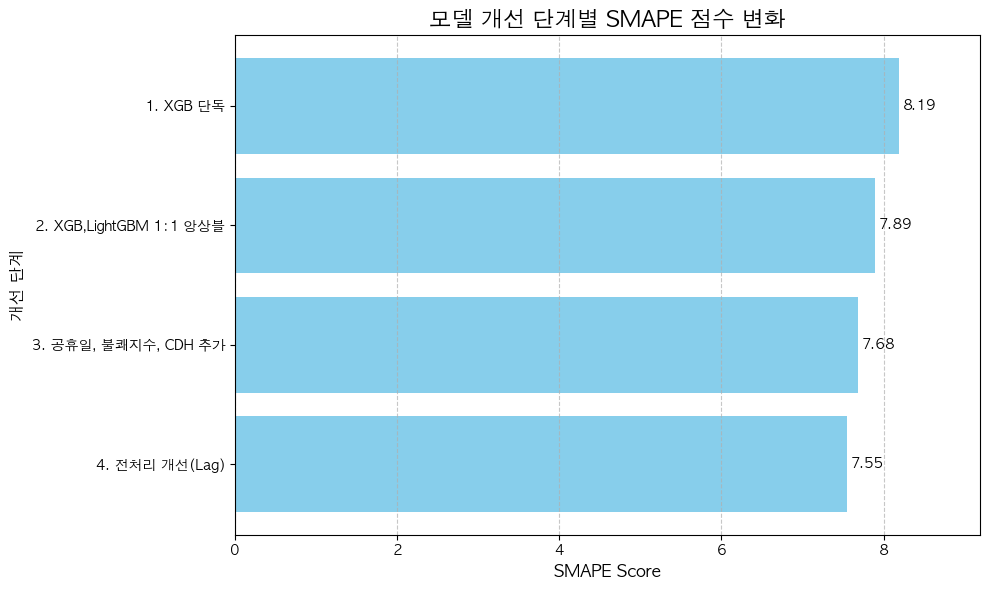

SMAPE 점수 변화 그래프를 'score_improvement_chart.png' 파일로 저장했습니다.


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------------------------------
# 맥북(macOS) 사용자용 폰트 설정
plt.rc('font', family='AppleGothic')
# ----------------------------------------------------------------

plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# 데이터 정의
stages = [
    '1. XGB 단독',
    '2. XGB,LightGBM 1:1 앙상블',
    '3. 공휴일, 불쾌지수, CDH 추가',
    '4. 전처리 개선(Lag)'
]
scores = [8.19, 7.89, 7.68, 7.55]

# 그래프 생성
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(stages, scores, color='skyblue')

# y축 순서 뒤집기 (1번이 위로 오게)
ax.invert_yaxis()

# 각 막대에 점수 표시
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 0.05
    ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

# 제목 및 라벨 설정
ax.set_title('모델 개선 단계별 SMAPE 점수 변화', fontsize=16)
ax.set_xlabel('SMAPE Score', fontsize=12)
ax.set_ylabel('개선 단계', fontsize=12)

# x축 범위 설정
ax.set_xlim(0, max(scores) + 1)

# 그리드 추가
ax.grid(axis='x', linestyle='--', alpha=0.7)

# 레이아웃 조정 및 저장
plt.tight_layout()
plt.savefig('score_improvement_chart.png')

plt.show()

print("SMAPE 점수 변화 그래프를 'score_improvement_chart.png' 파일로 저장했습니다.")

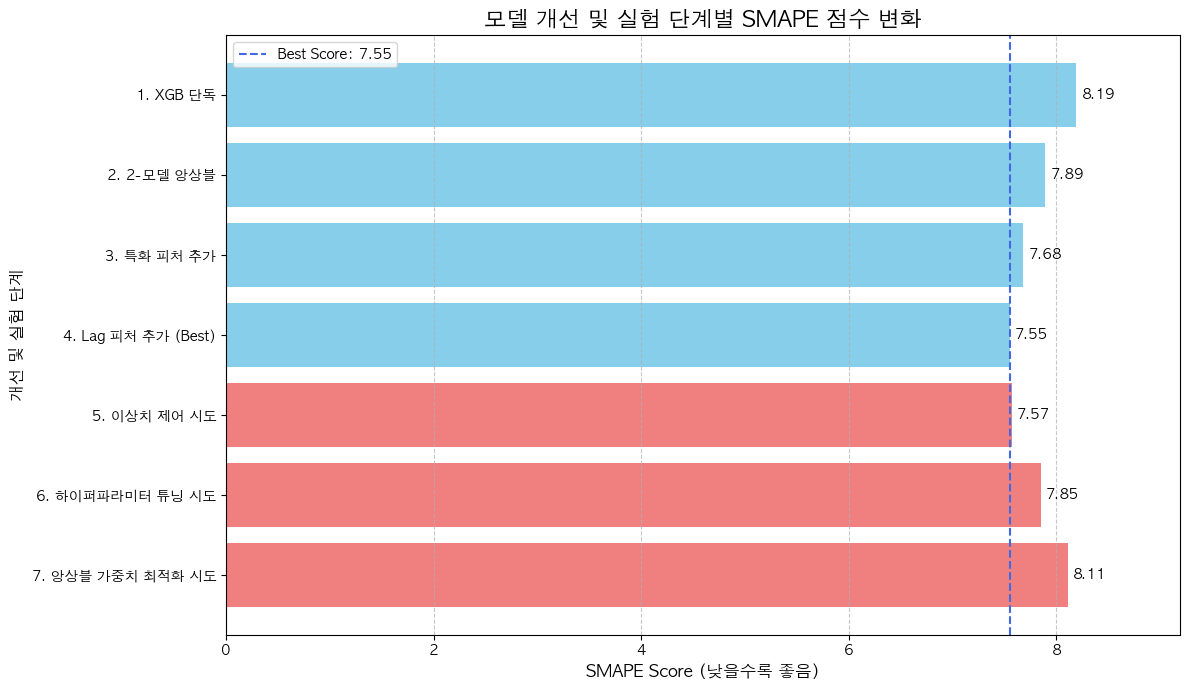

SMAPE 점수 변화 그래프를 'score_improvement_chart_new.png' 파일로 저장했습니다.


In [18]:
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------------------------------
# 맥북(macOS) 사용자용 폰트 설정
plt.rc('font', family='AppleGothic')
# ----------------------------------------------------------------

plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# --- 데이터 정의 (추가된 실험 결과 포함) ---
stages = [
    '1. XGB 단독',
    '2. 2-모델 앙상블',
    '3. 특화 피처 추가',
    '4. Lag 피처 추가 (Best)',
    '5. 이상치 제어 시도',
    '6. 하이퍼파라미터 튜닝 시도',
    '7. 앙상블 가중치 최적화 시도'
]
scores = [8.19, 7.89, 7.68, 7.55, 7.57, 7.85, 8.11]

# 성능이 향상된 단계와 그렇지 않은 단계를 색으로 구분
colors = ['skyblue'] * 4 + ['lightcoral'] * 3

# --- 그래프 생성 ---
fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.barh(stages, scores, color=colors)

# y축 순서 뒤집기 (1번이 위로 오게)
ax.invert_yaxis()

# 각 막대에 점수 표시
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 0.05
    ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

# 제목 및 라벨 설정
ax.set_title('모델 개선 및 실험 단계별 SMAPE 점수 변화', fontsize=16)
ax.set_xlabel('SMAPE Score (낮을수록 좋음)', fontsize=12)
ax.set_ylabel('개선 및 실험 단계', fontsize=12)

# x축 범위 설정
ax.set_xlim(0, max(scores) + 1)

# 최고 점수에 기준선 추가
best_score = min(scores)
ax.axvline(x=best_score, color='royalblue', linestyle='--', label=f'Best Score: {best_score:.2f}')
ax.legend()

# 그리드 추가
ax.grid(axis='x', linestyle='--', alpha=0.7)

# 레이아웃 조정 및 저장
plt.tight_layout()
# 파일명을 '_new'를 붙여 새로 저장
plt.savefig('score_improvement_chart_new.png')

plt.show()

print("SMAPE 점수 변화 그래프를 'score_improvement_chart_new.png' 파일로 저장했습니다.")

# 시도해본 방법론 코드 (실행X)

## 이상치 제어 시도

In [ ]:
   # ============================ ▼▼▼ 이상치 처리 코드 (새로운 전략) ▼▼▼ ============================
    # 3. 학습 데이터(train_part)에 대해서만 이상치 처리 수행
    
    # 7일(168시간) 이동 평균과 이동 표준편차를 계산합니다.
    rolling_mean = train_part['전력소비량(kWh)'].rolling(window=168, min_periods=1).mean()
    rolling_std = train_part['전력소비량(kWh)'].rolling(window=168, min_periods=1).std()

    # 이상치 경계 설정 (이동 평균에서 표준편차의 3배를 벗어나는 경우)
    upper_bound = rolling_mean + 3 * rolling_std
    lower_bound = rolling_mean - 3 * rolling_std

    # 이상치 탐지
    # (소비량은 음수가 없으므로 하한은 0으로 제한, 상한만 사용)
    outlier_indices = train_part[train_part['전력소비량(kWh)'] > upper_bound].index
    
    # 이상치를 NaN으로 변경 후 선형 보간
    if not outlier_indices.empty:
        train_part.loc[outlier_indices, '전력소비량(kWh)'] = np.nan
        train_part['전력소비량(kWh)'].interpolate(method='linear', inplace=True)
        
        # 보간 후에도 남아있을 수 있는 NaN을 최종 처리 (이전/이후 값으로 채우기)
        train_part['전력소비량(kWh)'].fillna(method='ffill', inplace=True)
        train_part['전력소비량(kWh)'].fillna(method='bfill', inplace=True)
    # ============================ ▲▲▲ 이상치 처리 코드 종료 ▲▲▲ ============================

## 하이퍼파라미터 최적화

In [ ]:
# --- 누락되었던 Helper 함수 및 Objective 함수 정의 ---

# SMAPE 계산 함수
def smape(y_true, y_pred):
    numerator = 2 * np.abs(y_pred - y_true)
    denominator = np.abs(y_true) + np.abs(y_pred)
    ratio = np.where(denominator == 0, 0, numerator / denominator)
    return np.mean(ratio) * 100

# Optuna Objective 함수 (여러 건물에 대한 평균 성능 평가)
def objective_multibuilding_lgb(trial, building_numbers):
    params = {
        'objective': 'regression_l1', 'metric': 'mae', 'random_state': SEED,
        'n_estimators': 1000, 'verbosity': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
    }
    scores = []
    for building_num in building_numbers:
        train_building = train_df[train_df['건물번호'] == building_num]
        split_date = train_building['일시'].max() - pd.Timedelta(days=7)
        train_part = train_building[train_building['일시'] < split_date]
        val_part = train_building[train_building['일시'] >= split_date]
        X_train, y_train = train_part[train_features.columns], train_part['전력소비량(kWh)']
        X_val, y_val = val_part[train_features.columns], val_part['전력소비량(kWh)']
        
        model = lgb.LGBMRegressor(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)])
        preds = model.predict(X_val)
        scores.append(smape(y_val, preds))
    return np.mean(scores)

# --- 샘플 개수별 튜닝 안정성 테스트 시작 ---
results = []
n_samples_to_test = range(2, 11) 

print("--- 샘플 개수별 튜닝 안정성 테스트 시작 ---")
optuna.logging.set_verbosity(optuna.logging.WARNING) # 로그 메시지 조정

for k in n_samples_to_test:
    print(f"\\n--- Testing with {k} samples ---")
    sample_building_numbers = np.random.choice(range(1, 101), k, replace=False).tolist()
    
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective_multibuilding_lgb(trial, sample_building_numbers), 
                   n_trials=30,
                   show_progress_bar=True)
    
    best_trial = study.best_trial
    result = {'n_samples': k, 'best_score': best_trial.value}
    result.update(best_trial.params)
    results.append(result)

# 결과 데이터프레임 생성 및 시각화
results_df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.lineplot(ax=axes[0], x='n_samples', y='best_score', data=results_df, marker='o')
axes[0].set_title('샘플 개수에 따른 최적 SMAPE 점수 변화', fontsize=15)
axes[0].set_xlabel('대표 건물 샘플 개수 (k)', fontsize=12)
axes[0].set_ylabel('Best SMAPE Score', fontsize=12)
axes[0].grid(True)
sns.lineplot(ax=axes[1], x='n_samples', y='learning_rate', data=results_df, marker='o')
axes[1].set_title('샘플 개수에 따른 최적 Learning Rate 값 변화', fontsize=15)
axes[1].set_xlabel('대표 건물 샘플 개수 (k)', fontsize=12)
axes[1].set_ylabel('Optimal Learning Rate', fontsize=12)
axes[1].grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# --- 시각화에 필요한 라이브러리 import ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ============================ ▼▼▼ 한글 폰트 설정 코드 추가 ▼▼▼ ============================
# macOS 환경에 맞는 AppleGothic 폰트로 설정합니다.
plt.rcParams['font.family'] = 'AppleGothic'
# 마이너스 기호가 깨지는 것을 방지합니다.
plt.rcParams['axes.unicode_minus'] = False
# ============================ ▲▲▲ 한글 폰트 설정 코드 종료 ▲▲▲ ============================

# --- 기존 시각화 코드 ---
# 결과 데이터프레임 생성 및 시각화
results_df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 시각화 1: 샘플 개수에 따른 성능 점수 변화
sns.lineplot(ax=axes[0], x='n_samples', y='best_score', data=results_df, marker='o')
axes[0].set_title('샘플 개수에 따른 최적 SMAPE 점수 변화', fontsize=15)
axes[0].set_xlabel('대표 건물 샘플 개수 (k)', fontsize=12)
axes[0].set_ylabel('Best SMAPE Score', fontsize=12)
axes[0].grid(True)

# 시각화 2: 샘플 개수에 따른 learning_rate 파라미터 값 변화
sns.lineplot(ax=axes[1], x='n_samples', y='learning_rate', data=results_df, marker='o')
axes[1].set_title('샘플 개수에 따른 최적 Learning Rate 값 변화', fontsize=15)
axes[1].set_xlabel('대표 건물 샘플 개수 (k)', fontsize=12)
axes[1].set_ylabel('Optimal Learning Rate', fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# --- 1. 모든 유형별 대표 건물 4개 자동 탐색 ---
representative_samples = {}
building_info = pd.read_csv('building_info.csv')
building_types = building_info['건물유형'].unique()

for b_type in building_types:
    encoded_col_name = f'건물_{b_type}'
    type_df = train_df[train_df[encoded_col_name] == 1]
    if type_df.empty: continue
    if len(type_df['건물번호'].unique()) <= 4:
        representative_samples[b_type] = type_df['건물번호'].unique().tolist()
        continue
    hourly_avg_profile = type_df.groupby(type_df['일시'].dt.hour)['전력소비량(kWh)'].mean()
    building_errors = {}
    for building_num in type_df['건물번호'].unique():
        building_data = type_df[type_df['건물번호'] == building_num]
        building_hourly_avg = building_data.groupby(building_data['일시'].dt.hour)['전력소비량(kWh)'].mean()
        building_hourly_avg = building_hourly_avg.reindex(hourly_avg_profile.index, fill_value=0)
        mse = np.mean((hourly_avg_profile - building_hourly_avg) ** 2)
        building_errors[building_num] = mse
    sorted_buildings = sorted(building_errors.items(), key=lambda item: item[1])
    top_4_buildings = [b[0] for b in sorted_buildings[:4]]
    representative_samples[b_type] = top_4_buildings

# --- 2. 튜닝에 사용할 최종 샘플 리스트 자동 생성 ---
types_to_sample = ['아파트', '백화점', '공공', '병원', '상용'] 
sample_building_numbers = [representative_samples[t][0] for t in types_to_sample]
print(f"--- 최종 튜닝 샘플 건물 (5개): {sample_building_numbers} ---")

In [ ]:
# ============================ ▼▼▼ SMAPE 함수 정의 추가 ▼▼▼ ============================
# SMAPE 계산 함수
def smape(y_true, y_pred):
    numerator = 2 * np.abs(y_pred - y_true)
    denominator = np.abs(y_true) + np.abs(y_pred)
    ratio = np.where(denominator == 0, 0, numerator / denominator)
    return np.mean(ratio) * 100
# ============================ ▲▲▲ SMAPE 함수 정의 종료 ▲▲▲ ============================

In [ ]:
# Optuna Objective 함수 (LightGBM용)
def objective_multibuilding_lgb(trial, building_numbers):
    params = {
        'objective': 'regression_l1', 'metric': 'mae', 'random_state': SEED,
        'n_estimators': 1000, 'verbosity': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
    }
    scores = []
    for building_num in building_numbers:
        train_building = train_df[train_df['건물번호'] == building_num]
        split_date = train_building['일시'].max() - pd.Timedelta(days=7)
        train_part = train_building[train_building['일시'] < split_date]
        val_part = train_building[train_building['일시'] >= split_date]
        X_train, y_train = train_part[train_features.columns], train_part['전력소비량(kWh)']
        X_val, y_val = val_part[train_features.columns], val_part['전력소비량(kWh)']
        
        model = lgb.LGBMRegressor(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)])
        preds = model.predict(X_val)
        scores.append(smape(y_val, preds))
    return np.mean(scores)

# Optuna 스터디 실행
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(lambda trial: objective_multibuilding_lgb(trial, sample_building_numbers), n_trials=100, show_progress_bar=True)

# 최적 파라미터 저장 및 출력
best_params_lgb = study_lgb.best_trial.params


In [ ]:
# 저장된 best_params_lgb 변수를 일반 print 함수로 출력합니다.
print("\n--- Best Params for LightGBM ---")
print(best_params_lgb)

In [ ]:
import pprint

# Optuna Objective 함수 (XGBoost용)
def objective_multibuilding_xgb(trial, building_numbers):
    params = {
        'random_state': SEED, 'n_estimators': 1000, 'n_jobs': -1, 'early_stopping_rounds': 50,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
    }
    scores = []
    for building_num in building_numbers:
        train_building = train_df[train_df['건물번호'] == building_num]
        split_date = train_building['일시'].max() - pd.Timedelta(days=7)
        train_part = train_building[train_building['일시'] < split_date]
        val_part = train_building[train_building['일시'] >= split_date]
        X_train, y_train = train_part[train_features.columns], train_part['전력소비량(kWh)']
        X_val, y_val = val_part[train_features.columns], val_part['전력소비량(kWh)']
        
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        preds = model.predict(X_val)
        scores.append(smape(y_val, preds))
    return np.mean(scores)

# Optuna 스터디 실행
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(lambda trial: objective_multibuilding_xgb(trial, sample_building_numbers), n_trials=100, show_progress_bar=True)

# 최적 파라미터 저장 및 출력
best_params_xgb = study_xgb.best_trial.params
best_params_xgb.pop('early_stopping_rounds', None) 
print("\n--- Best Params for XGBoost ---")
pprint.pprint(best_params_xgb)

In [ ]:
import pprint

# Optuna Objective 함수 (CatBoost용)
def objective_multibuilding_cat(trial, building_numbers):
    params = {
        'random_state': SEED, 'n_estimators': 1000, 'verbose': 0,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 5, 12),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'rsm': trial.suggest_float('rsm', 0.7, 1.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 2, 10),
    }
    scores = []
    for building_num in building_numbers:
        train_building = train_df[train_df['건물번호'] == building_num]
        split_date = train_building['일시'].max() - pd.Timedelta(days=7)
        train_part = train_building[train_building['일시'] < split_date]
        val_part = train_building[train_building['일시'] >= split_date]
        X_train, y_train = train_part[train_features.columns], train_part['전력소비량(kWh)']
        X_val, y_val = val_part[train_features.columns], val_part['전력소비량(kWh)']
        
        model = CatBoostRegressor(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, use_best_model=True)
        preds = model.predict(X_val)
        scores.append(smape(y_val, preds))
    return np.mean(scores)

# Optuna 스터디 실행
study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(lambda trial: objective_multibuilding_cat(trial, sample_building_numbers), n_trials=100, show_progress_bar=True)

# 최적 파라미터 저장 및 출력
best_params_cat = study_cat.best_trial.params
print("\n--- Best Params for CatBoost ---")
pprint.pprint(best_params_cat)

In [ ]:
# 결과를 저장할 딕셔너리 확장
all_y_vals = {}
xgb_val_preds, lgb_val_preds, cat_val_preds = {}, {}, {} # 모델별로 분리
ensemble_val_preds = {}

# 최종 예측 결과 저장용 리스트
final_predictions = []

# --- 모델 학습 및 예측 루프 ---
for building_num in tqdm(range(1, 101)):
    # ... (데이터 필터링 및 분리, 모델 정의 부분은 기존과 동일) ...
    train_building = train_df[train_df['건물번호'] == building_num]
    test_building = test_df[test_df['건물번호'] == building_num].copy()
    split_date = train_building['일시'].max() - pd.Timedelta(days=7)
    train_part = train_building[train_building['일시'] < split_date]
    val_part = train_building[train_building['일시'] >= split_date]
    X_train, y_train = train_part[train_features.columns], train_part['전력소비량(kWh)']
    X_val, y_val = val_part[train_features.columns], val_part['전력소비량(kWh)']
    
    model_xgb = xgb.XGBRegressor(random_state=SEED, n_estimators=1000, **best_params_xgb)
    model_lgb = lgb.LGBMRegressor(random_state=SEED, n_estimators=1000, **best_params_lgb)
    model_cat = CatBoostRegressor(random_state=SEED, n_estimators=1000, **best_params_cat)

    # 모델 학습
    model_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    model_lgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)])
    model_cat.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, use_best_model=True)

    # 검증 데이터에 대한 예측
    val_pred_xgb = model_xgb.predict(X_val)
    val_pred_lgb = model_lgb.predict(X_val)
    val_pred_cat = model_cat.predict(X_val)
    
    # ============================ ▼▼▼ 코드 수정 부분 ▼▼▼ ============================
    # 모든 모델의 검증 예측 결과를 각각 저장
    all_y_vals[building_num] = val_part[['일시', '전력소비량(kWh)']].copy()
    xgb_val_preds[building_num] = val_pred_xgb 
    lgb_val_preds[building_num] = val_pred_lgb
    cat_val_preds[building_num] = val_pred_cat
    ensemble_val_preds[building_num] = (val_pred_xgb + val_pred_lgb + val_pred_cat) / 3 # 단순 평균 결과도 저장
    # ============================ ▲▲▲ 코드 수정 부분 ▲▲▲ ============================

    # ... (테스트 데이터 재귀적 예측 부분은 우선 그대로 둡니다) ...
    history_data = train_building.iloc[-168:].copy()
    for i in range(len(test_building)):
        current_test_row = test_building.iloc[[i]]
        combined_df = pd.concat([history_data, current_test_row], ignore_index=True)
        for lag in [1, 24, 168]:
            col_name = f'lag_{lag}h'
            combined_df[col_name] = combined_df['전력소비량(kWh)'].shift(lag)
        final_test_row = combined_df.iloc[[-1]][train_features.columns]
        pred_xgb = model_xgb.predict(final_test_row)[0]
        pred_lgb = model_lgb.predict(final_test_row)[0]
        pred_cat = model_cat.predict(final_test_row)[0]
        ensemble_prediction = (pred_xgb + pred_lgb + pred_cat) / 3
        final_predictions.append(ensemble_prediction)
        current_test_row.loc[:, '전력소비량(kWh)'] = ensemble_prediction
        history_data = pd.concat([history_data, current_test_row], ignore_index=True).iloc[1:]

# --- 최종 제출 파일 생성 ---
# submission_df = pd.read_csv('sample_submission.csv')
# submission_df['answer'] = final_predictions
# submission_df.to_csv('submission_temp.csv', index=False)
# print("\\n--- Temp submission file created ---")

## 앙상블 가중치 최적화 시도

In [ ]:
# --- 1. 검증 결과 취합 ---
y_true_all = np.concatenate([val['전력소비량(kWh)'].values for val in all_y_vals.values()])
xgb_preds_all = np.concatenate(list(xgb_val_preds.values()))
lgb_preds_all = np.concatenate(list(lgb_val_preds.values()))
cat_preds_all = np.concatenate(list(cat_val_preds.values()))

best_smape = 100
best_weights = None

# --- 2. 최적의 가중치 탐색 (Grid Search) ---
# XGB, LGBM, CatBoost의 가중치를 0.1 단위로 변경하며 탐색
print("--- Finding Optimal Ensemble Weights ---")
for w_xgb in np.arange(0, 1.1, 0.1):
    for w_lgb in np.arange(0, 1.1 - w_xgb, 0.1):
        w_cat = 1 - w_xgb - w_lgb
        
        # 가중치 합이 1이 되도록 조정 (부동소수점 오차 방지)
        w_cat = round(w_cat, 1)
        if w_cat < 0: continue

        # 가중 평균 앙상블 예측 계산
        ensemble_pred = (xgb_preds_all * w_xgb + 
                         lgb_preds_all * w_lgb + 
                         cat_preds_all * w_cat)
        
        current_smape = smape(y_true_all, ensemble_pred)
        
        if current_smape < best_smape:
            best_smape = current_smape
            best_weights = (w_xgb, w_lgb, w_cat)

print(f"\\n--- Optimal Ensemble Weights Found! ---")
print(f"Best SMAPE: {best_smape:.4f}")
print(f"Best Weights (XGB, LGBM, CAT): {best_weights}")

# 찾은 가중치를 변수에 저장
opt_weights = best_weights

In [ ]:
# ============================ ▼▼▼ 코드 수정 부분 ▼▼▼ ============================
# 최종 예측 결과 저장용 리스트를 다시 초기화합니다.
final_predictions = []
# 2단계에서 찾은 최적의 가중치를 변수에 할당합니다.
w_xgb, w_lgb, w_cat = opt_weights
# ============================ ▲▲▲ 코드 수정 부분 ▲▲▲ ============================

# --- 모델 학습 및 예측 루프 ---
for building_num in tqdm(range(1, 101)):
    # ... (데이터 필터링, 분리, 모델 정의, 학습, 검증 예측 부분은 모두 동일) ...
    train_building = train_df[train_df['건물번호'] == building_num]
    test_building = test_df[test_df['건물번호'] == building_num].copy()
    split_date = train_building['일시'].max() - pd.Timedelta(days=7)
    train_part = train_building[train_building['일시'] < split_date]
    val_part = train_building[train_building['일시'] >= split_date]
    X_train, y_train = train_part[train_features.columns], train_part['전력소비량(kWh)']
    X_val, y_val = val_part[train_features.columns], val_part['전력소비량(kWh)']
    
    model_xgb = xgb.XGBRegressor(random_state=SEED, n_estimators=1000, **best_params_xgb)
    model_lgb = lgb.LGBMRegressor(random_state=SEED, n_estimators=1000, **best_params_lgb)
    model_cat = CatBoostRegressor(random_state=SEED, n_estimators=1000, **best_params_cat)

    model_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    model_lgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)])
    model_cat.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, use_best_model=True)
    
    # --- 테스트 데이터에 대한 재귀적 예측 ---
    history_data = train_building.iloc[-168:].copy()
    for i in range(len(test_building)):
        current_test_row = test_building.iloc[[i]]
        combined_df = pd.concat([history_data, current_test_row], ignore_index=True)
        for lag in [1, 24, 168]:
            col_name = f'lag_{lag}h'
            combined_df[col_name] = combined_df['전력소비량(kWh)'].shift(lag)
        final_test_row = combined_df.iloc[[-1]][train_features.columns]
        
        pred_xgb = model_xgb.predict(final_test_row)[0]
        pred_lgb = model_lgb.predict(final_test_row)[0]
        pred_cat = model_cat.predict(final_test_row)[0]
        
        # ============================ ▼▼▼ 코드 수정 부분 ▼▼▼ ============================
        # 단순 평균 대신 최적 가중치를 적용한 가중 평균으로 변경
        ensemble_prediction = (pred_xgb * w_xgb + pred_lgb * w_lgb + pred_cat * w_cat)
        # ============================ ▲▲▲ 코드 수정 부분 ▲▲▲ ============================

        final_predictions.append(ensemble_prediction)
        current_test_row.loc[:, '전력소비량(kWh)'] = ensemble_prediction
        history_data = pd.concat([history_data, current_test_row], ignore_index=True).iloc[1:]

# --- 최종 제출 파일 생성 ---
submission_df = pd.read_csv('sample_submission.csv')
submission_df['answer'] = final_predictions
submission_df.to_csv('submission_weighted_ensemble.csv', index=False)
print("\\n--- Weighted Ensemble submission file 'submission_weighted_ensemble.csv' created successfully! ---")